# Analysis of Human Dynamics - Coursework
Student number: 201411241
  
## Can socio-demographic composiations of LSOAs predict crime rates?

Import libraries and data

In [141]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection  import train_test_split 
import statsmodels.formula.api as sm
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster, metrics
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
crime_data = pd.read_csv('crime_data/man_cr_med.csv').set_index('lsoa')
all_data = pd.read_csv('data/manchester_data.csv').set_index('GEO_CODE').join(crime_data, how='left')

la_data = pd.read_csv('shapefiles/manlsoala.csv').set_index('geo_code')
lsoa_data = gpd.read_file('shapefiles/man_lsoa_all.shp').set_index('geo_code').join(la_data, how = 'left')

In [3]:
all_data.loc[all_data.vi_crime_count.isnull(), 'vi_crime_count'] = all_data['vi_crime_count'].median()

In [4]:
all_data.head()

,age_mean,age_median,badhealth,centheat,nodepr,depr_4+,depr_3+,depr_2+,studenthhold,onefam_hhold,nocars,eth_hhi,ethwhite,vi_crime_count
GEO_CODE,,,,,,,,,,,,,,
E01004766,42.10929,42.0,0.075377,0.937107,0.350943,0.002516,0.051572,0.298113,0.001258,0.510692,0.354717,0.176145,0.863693,31.0
E01004767,40.15316,39.0,0.048868,0.958333,0.446615,0.003906,0.046875,0.221354,0.010417,0.558594,0.244792,0.172369,0.796782,39.0
E01004768,39.94941,42.0,0.016864,0.991736,0.641322,0.000000,0.008264,0.084298,0.000000,0.796694,0.044628,0.221215,0.937539,7.0
E01004769,41.63690,42.5,0.035202,0.982482,0.554745,0.001460,0.016058,0.138686,0.000000,0.645255,0.132847,0.197436,0.930248,17.0
E01004770,44.31058,45.0,0.055290,0.978896,0.452922,0.001623,0.022727,0.194805,0.000000,0.733766,0.144481,0.136553,0.822526,13.0


### Preprocess data

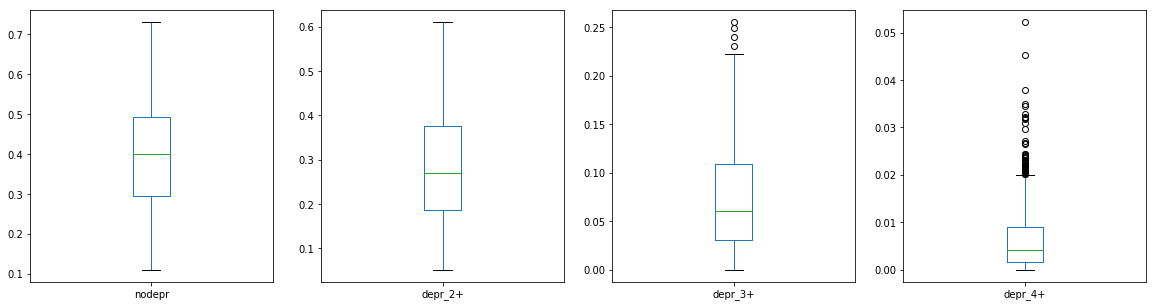

In [5]:
all_data[['nodepr', 'depr_2+', 'depr_3+', 'depr_4+']].plot(kind='box', subplots=True, figsize=(20, 5))
plt.show()

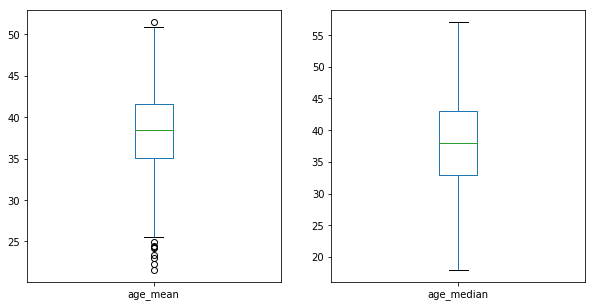

In [6]:
all_data[['age_mean', 'age_median']].plot(kind='box', subplots=True, figsize=(10, 5))
plt.show()

In [7]:
to_keep = ['age_median', 'badhealth', 'studenthhold', 'onefam_hhold', 'eth_hhi', 'depr_2+', 'nocars']
to_keep_z = ['vi_crime_count']

for variable in to_keep:
    var_z = variable + '_z'
    to_keep_z.append(var_z)
    all_data[var_z] = (all_data[variable] - all_data[variable].mean())/all_data[variable].std(ddof=0)

for variable in to_keep_z:
    all_data[variable] = all_data[variable].fillna(all_data[variable].median())

In [8]:
all_data[to_keep_z].head()

,vi_crime_count,age_median_z,badhealth_z,studenthhold_z,onefam_hhold_z,eth_hhi_z,depr_2+_z,nocars_z
GEO_CODE,,,,,,,,
E01004766,31.0,0.630702,0.284958,-0.161325,-0.855892,-0.031264,0.130367,0.360701
E01004767,39.0,0.172698,-0.652414,0.115203,-0.440988,-0.080929,-0.522746,-0.309699
E01004768,7.0,0.630702,-1.784057,-0.199303,1.621328,0.561534,-1.688907,-1.530434
E01004769,17.0,0.707036,-1.135634,-0.199303,0.309636,0.248769,-1.226136,-0.992417
E01004770,13.0,1.088706,-0.425316,-0.199303,1.076275,-0.552008,-0.748641,-0.921466


In [9]:
# join df
spatial_data = lsoa_data.join(all_data[to_keep_z], how = 'right')

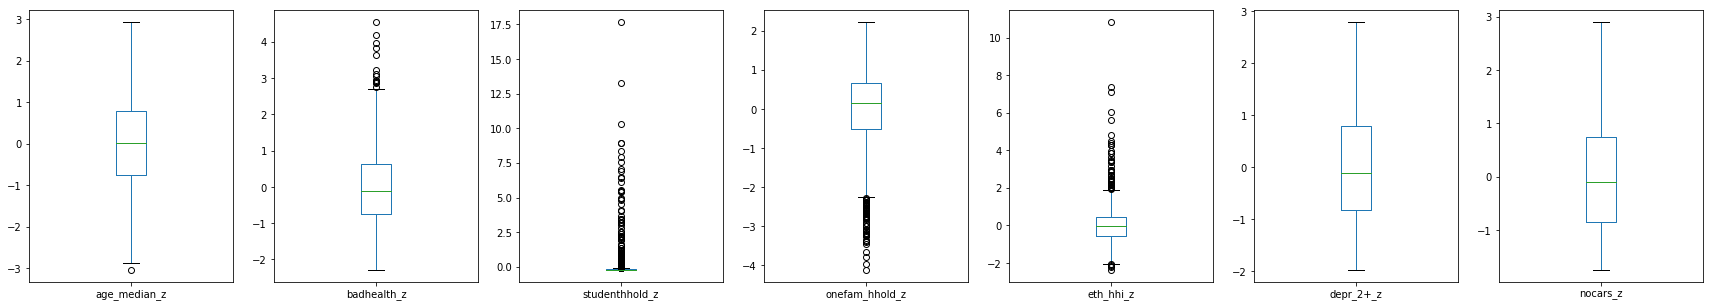

In [10]:
# box plots
spatial_data[to_keep_z].drop('vi_crime_count', axis=1).plot(kind='box', subplots=True, figsize=(30, 5))
plt.show()

In [11]:
# too many 0's so do not log transfrom 
len(spatial_data['studenthhold_z'].value_counts(0))

435

In [12]:
to_keep = ['age_median_z', 'badhealth_z', 'onefam_hhold_z', 'eth_hhi_z', 'depr_2+_z', 'nocars_z', 'studenthhold_z']
man_data = spatial_data[to_keep].dropna(axis = 0)

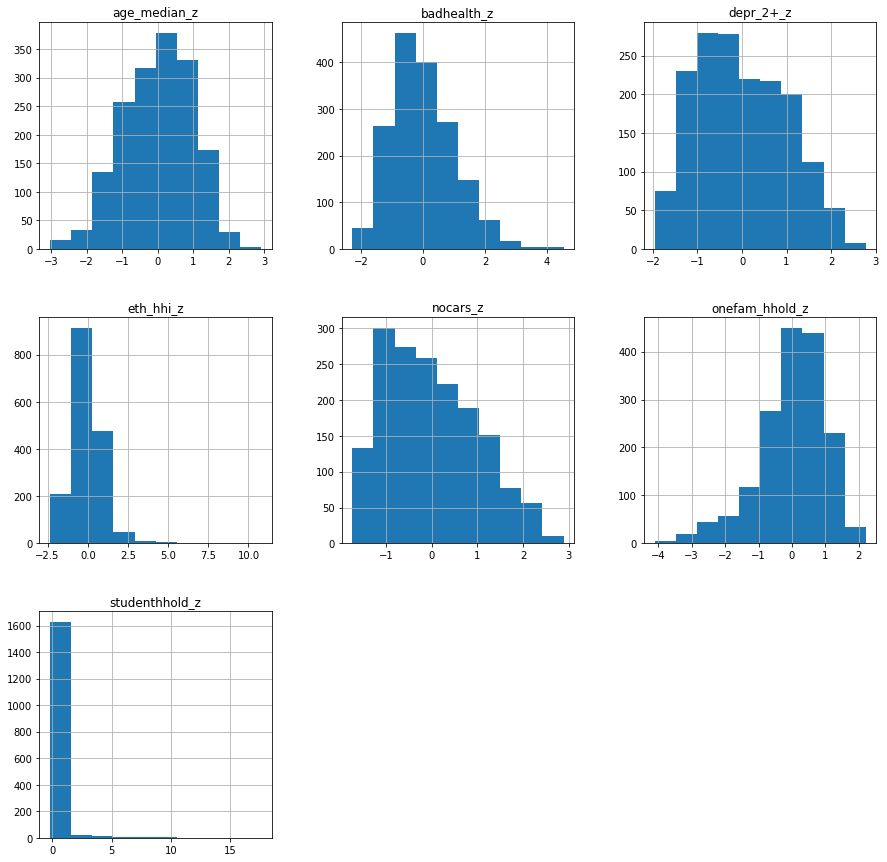

In [13]:
man_data.hist(figsize=(15, 15))
plt.show()

In [14]:
man_data.describe().loc[['mean', 'std'], :]

,age_median_z,badhealth_z,onefam_hhold_z,eth_hhi_z,depr_2+_z,nocars_z,studenthhold_z
mean,-1.359078e-16,-7.644811e-17,4.247117e-17,1.019308e-16,3.397694e-16,1.868732e-16,1.698847e-17
std,1.000299e+00,1.000299e+00,1.000299e+00,1.000299e+00,1.000299e+00,1.000299e+00,1.000299e+00


In [15]:
man_data.corr()

,age_median_z,badhealth_z,onefam_hhold_z,eth_hhi_z,depr_2+_z,nocars_z,studenthhold_z
age_median_z,1.000000,-0.141405,0.528518,0.176648,-0.436927,-0.660278,-0.392291
badhealth_z,-0.141405,1.000000,-0.400380,-0.077726,0.883362,0.673749,-0.176508
onefam_hhold_z,0.528518,-0.400380,1.000000,0.268577,-0.464719,-0.797974,-0.477335
eth_hhi_z,0.176648,-0.077726,0.268577,1.000000,-0.143013,-0.250905,-0.028089
depr_2+_z,-0.436927,0.883362,-0.464719,-0.143013,1.000000,0.815537,-0.072292
nocars_z,-0.660278,0.673749,-0.797974,-0.250905,0.815537,1.000000,0.265480
studenthhold_z,-0.392291,-0.176508,-0.477335,-0.028089,-0.072292,0.265480,1.000000


## K-Means & PCA

### How many cluster?

In [16]:
# Perform PCA
pca = PCA(n_components=None) # Create an instance of the PCA class

# Fit the data to the model
pcaResults = pca.fit_transform(man_data.iloc[:,1:]) # Remove crime_med for the pca
explained_variance = pca.explained_variance_ratio_ # Extract the varience

In [17]:
# Show how much variance each PC explains
print(np.around(explained_variance, 3))

[0.521 0.237 0.158 0.05  0.026 0.008]


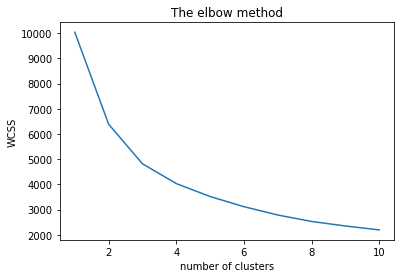

In [18]:
# Import Kmeans Library
from sklearn.cluster import KMeans

# use the elbow method
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(pcaResults)
    wcss.append(kmeans.inertia_)
    
# Plot the WCSS results
plt.plot(range(1,11), wcss)
plt.title('The elbow method')
plt.xlabel('number of clusters')
plt.ylabel('WCSS')
plt.show()

### 2 clusters --> so check if clusters respond to crime data --> do median split for 2 clusters

In [19]:
# do median split for violent crime count
spatial_data['crime_cat'] = 'Below Median'
spatial_data.loc[spatial_data.vi_crime_count >= spatial_data.vi_crime_count.median(), 'crime_cat'] = 'Above Median'

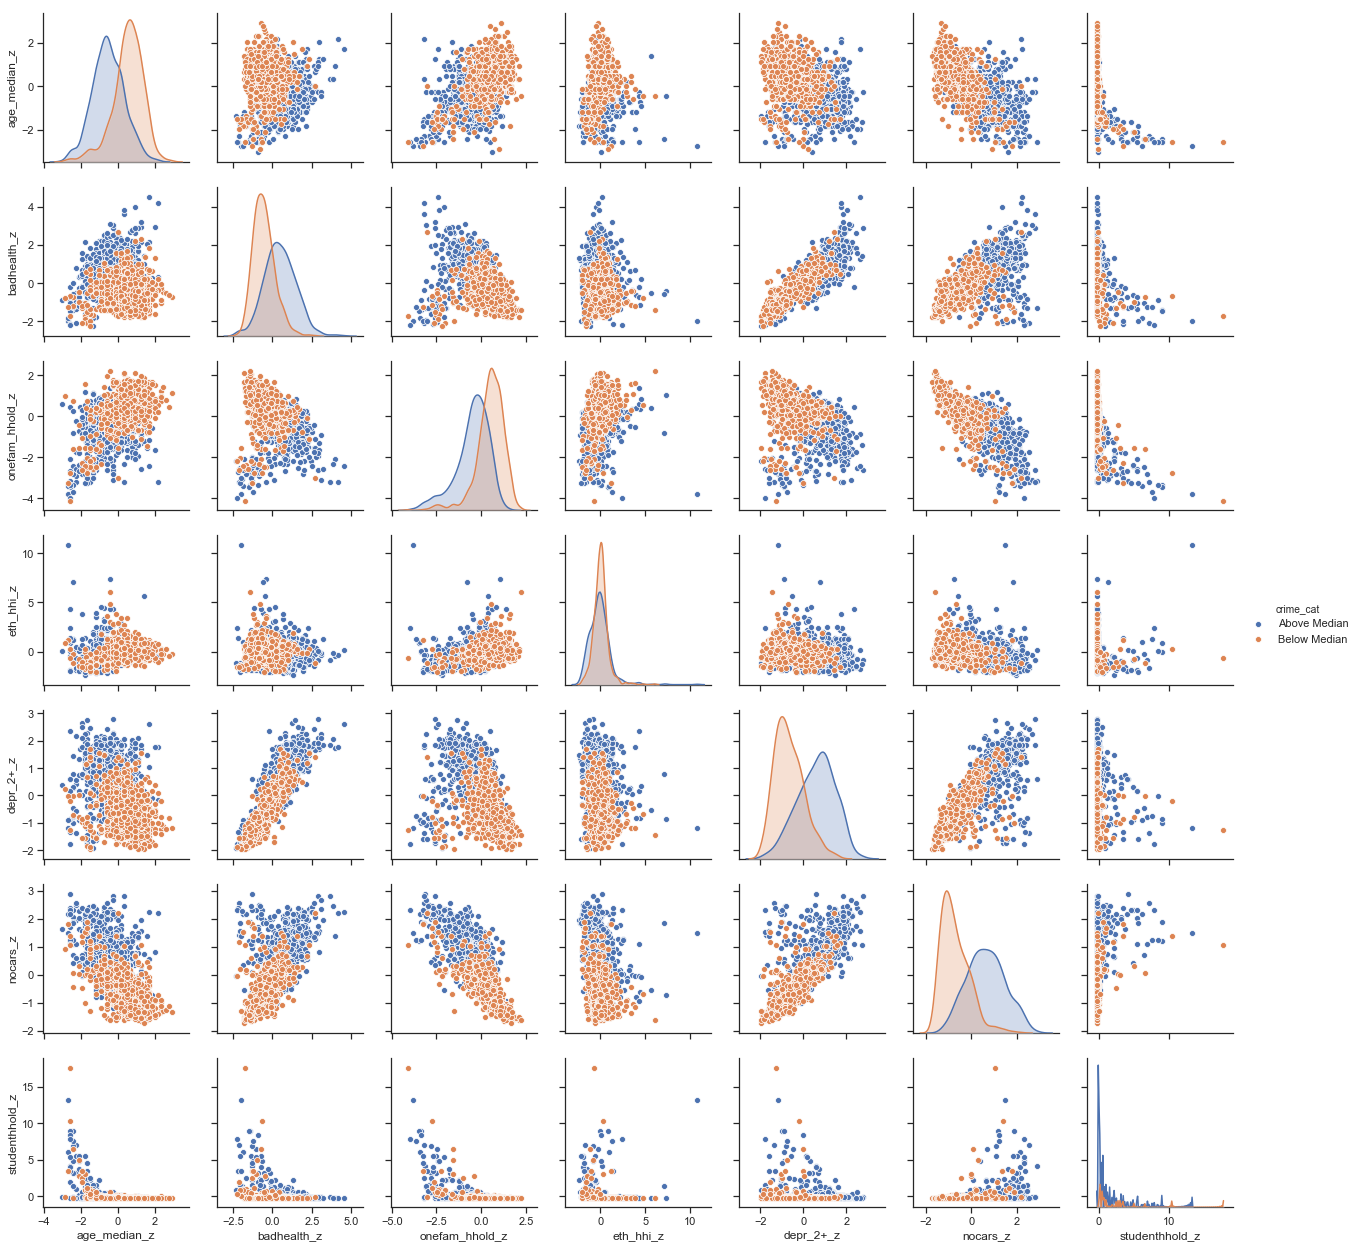

In [20]:
to_keep.append('crime_cat')
man_data = spatial_data[to_keep]

sns.set(style="ticks")
sns.pairplot(man_data, hue = 'crime_cat')

In [21]:
man_data[man_data.crime_cat == 'Above Median'].describe().loc[['mean', 'std'], :]

,age_median_z,badhealth_z,onefam_hhold_z,eth_hhi_z,depr_2+_z,nocars_z,studenthhold_z
mean,-0.517781,0.499647,-0.482515,-0.059677,0.610487,0.662865,0.096812
std,0.855993,0.998642,0.934099,1.158841,0.868259,0.829746,1.130913


In [22]:
man_data[man_data.crime_cat == 'Below Median'].describe().loc[['mean', 'std'], :]

,age_median_z,badhealth_z,onefam_hhold_z,eth_hhi_z,depr_2+_z,nocars_z,studenthhold_z
mean,0.543797,-0.524752,0.506759,0.062676,-0.641161,-0.696171,-0.101676
std,0.839752,0.683439,0.796484,0.796625,0.676366,0.618356,0.830210


## Start making clusters & explore

### Raw Clusters

In [23]:
km2 = cluster.KMeans(n_clusters=2)

np.random.seed(1234)
k2cls = km2.fit(man_data.drop('crime_cat', axis = 1))

k2cls.labels_

array([0, 1, 1, ..., 0, 0, 0])

In [24]:
# view the size of the clusters
man_data.groupby(k2cls.labels_)\
        .size()

0    764
1    909
dtype: int64

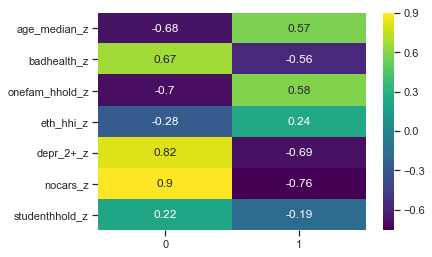

In [26]:
# means of clusters across variables
sns.heatmap(man_data.groupby(k2cls.labels_)\
                    .mean()\
                    .T,
            annot=True,
            cmap='viridis');

In [25]:
# add cluster information to df
cluster_data = man_data.reset_index()[['GEO_CODE', 'crime_cat']].join(pd.Series(k2cls.labels_, name='cluster'))

cluster_data['cluster_lab'] = 'Cluster 2'
cluster_data.loc[cluster_data.cluster < 0.5, 'cluster_lab'] = 'Cluster 1'

cluster_2 = cluster_data[['GEO_CODE', 'cluster_lab']].set_index('GEO_CODE')

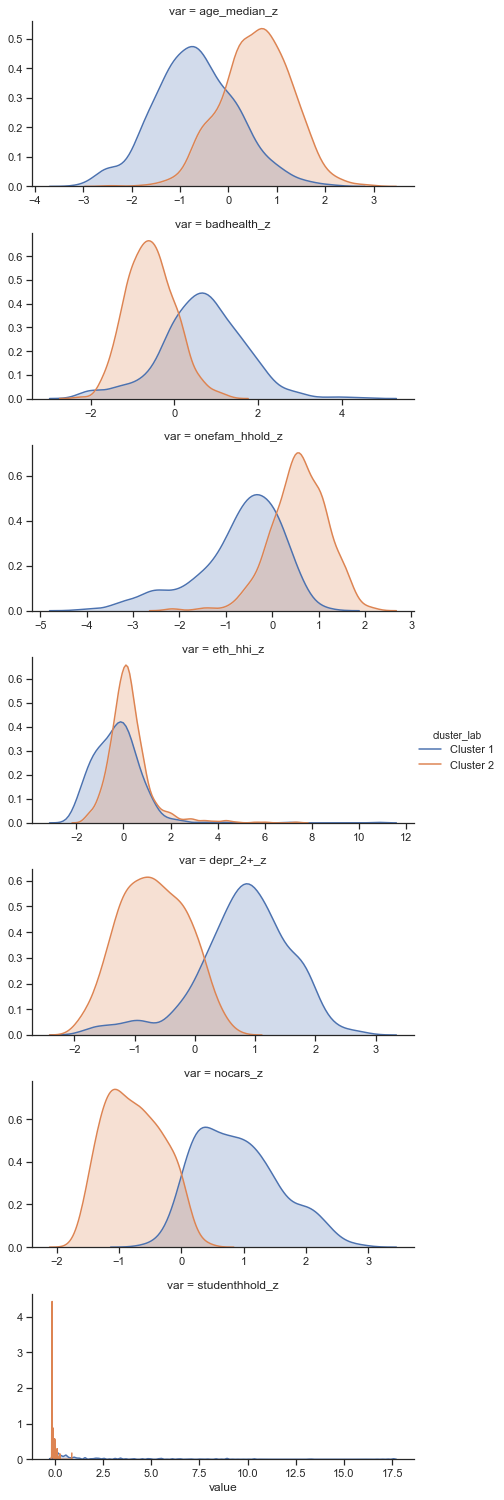

In [27]:
# plot variables by k-means clusters
tidy = man_data.drop('crime_cat', axis = 1)\
                .stack()\
                .reset_index()\
                .rename(columns={0: 'value','level_1': 'var'})\
                .set_index('GEO_CODE')\
                .join(cluster_2)

g = sns.FacetGrid(row='var', hue='cluster_lab', data=tidy,
                  sharey=False, sharex=False, aspect=2)
g.map(sns.kdeplot, 'value', shade=True).add_legend();


### PCA-based clusters

In [28]:
# Perform PCA using 2 components
pca = PCA(n_components = 2).fit_transform(man_data.drop('crime_cat', axis = 1))

# perform k-means on pca (using 2 clusters)
k_pca = cluster.KMeans(n_clusters=2).fit(pca)

In [29]:
colour_map = {
    'Above Median': 'blue',
    'Below Median' : 'orange',
    1 : 'blue',
    0 : 'orange',
}

# Create an array of colours based on the target column
pca_colours = [colour_map[c] for c in k_pca.labels_]
raw_colours = [colour_map[c] for c in (1 - k2cls.labels_)] # inverst to get the colours synchronised 
org_colours = [colour_map[c] for c in man_data['crime_cat']]

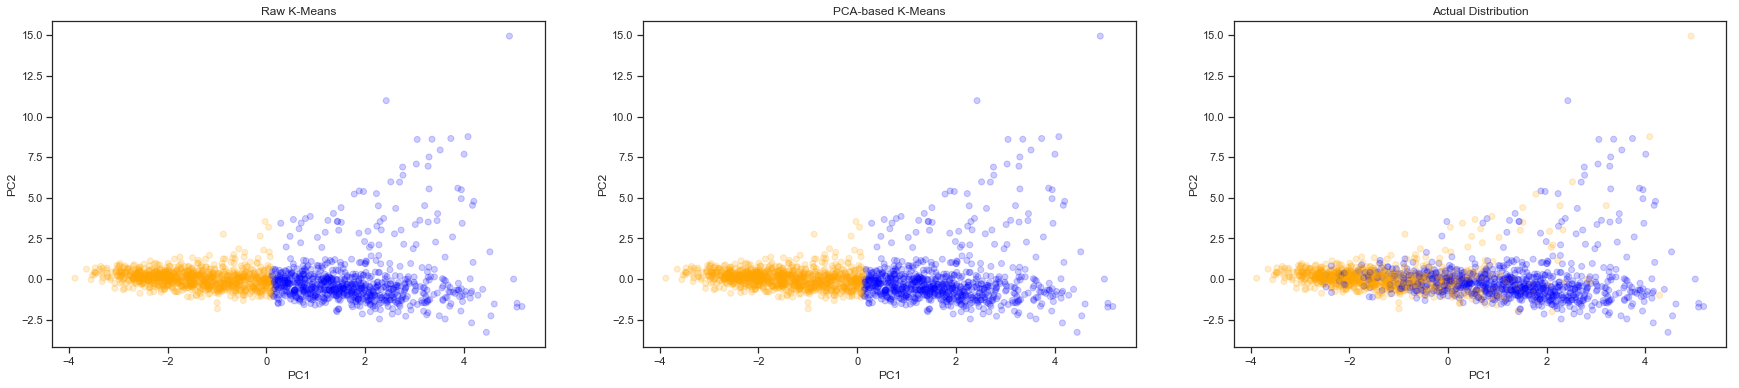

In [30]:
# k=2 as the original clustering
k_pca = cluster.KMeans(n_clusters=2).fit(pca)

f, axs = plt.subplots(1, 3, figsize=(30, 6))

axs[0].scatter(pca[:, 0], pca[:, 1], 
               c=raw_colours,
               alpha=0.2);
axs[0].set_title('Raw K-Means')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')

axs[1].scatter(pca[:, 0], pca[:, 1], 
               c=pca_colours,
               alpha=0.2);
axs[1].set_title('PCA-based K-Means')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')

axs[2].scatter(pca[:, 0], pca[:, 1], 
               c=org_colours,
               alpha=0.2);
axs[2].set_title('Actual Distribution')
axs[2].set_xlabel('PC1')
axs[2].set_ylabel('PC2')

plt.show()

In [39]:
# add PCA-based K-means clusters to df
cluster_pca = man_data.reset_index()[['GEO_CODE', 'crime_cat']].join(pd.Series(k_pca.labels_, name='cluster'))

cluster_pca['cluster_lab'] = 'Cluster 1'
cluster_pca.loc[cluster_pca.cluster < 0.5, 'cluster_lab'] = 'Cluster 2'

cluster_pca_2 = cluster_data[['GEO_CODE', 'cluster_lab']].set_index('GEO_CODE')

Text(0.5, 1.0, 'Median Split Crime Distribution')

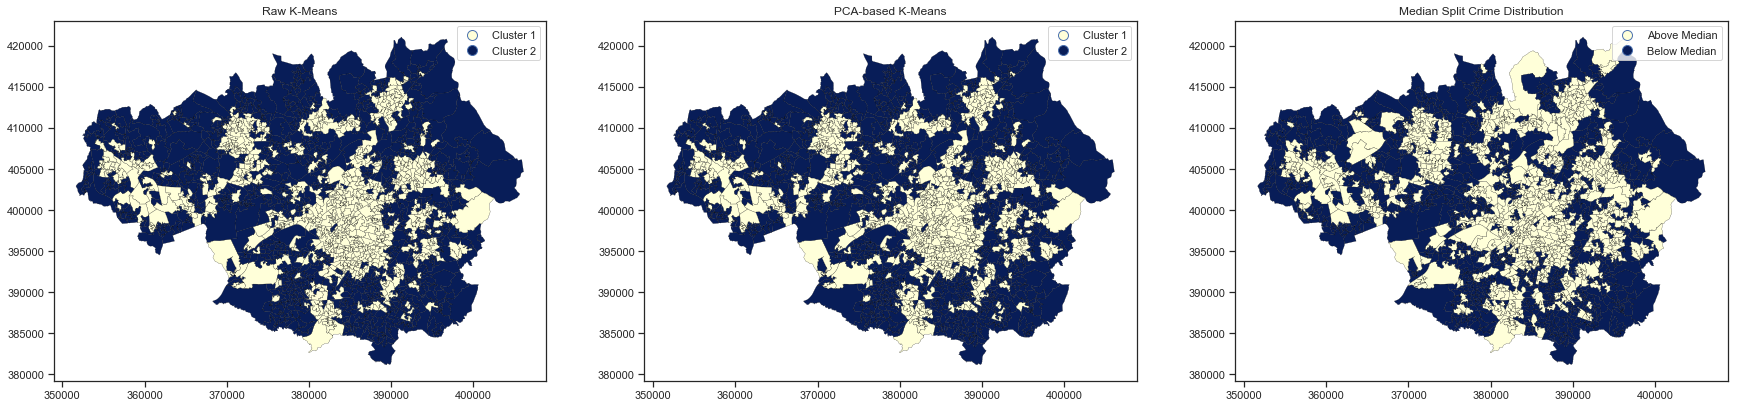

In [40]:
# view spatial distribution

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30, 15))

# K-Means Raw
spatial_data.join(cluster_2, how = 'right')\
            .plot(ax = ax1,
                  column='cluster_lab', 
                  cmap='YlGnBu',
                  linewidth=0.2, edgecolor='black',
                  legend=True
            )\
            .set_title("Raw K-Means")


# K-Means PCA-based
spatial_data.join(cluster_pca_2, how = 'right')\
            .plot(ax=ax2,
                  column='cluster_lab', 
                  cmap='YlGnBu',
                  linewidth=0.2, edgecolor='black', 
                  legend=True
                 )\
            .set_title("PCA-based K-Means")


# Median split map
spatial_data.plot(ax=ax3,
                  column='crime_cat', 
                  cmap='YlGnBu',
                  linewidth=0.2, edgecolor='black', 
                  legend=True
                 )\
            .set_title("Median Split Crime Distribution")

### Evaluating the results

In [41]:
# show crosstab to see how many were correct / incorrect
pd.crosstab(cluster_data.crime_cat, cluster_data.cluster_lab)

cluster_lab,Cluster 1,Cluster 2
crime_cat,,
Above Median,653,204
Below Median,111,705


In [42]:
# show crosstab to see how many were correct / incorrect - Raw
pd.crosstab(cluster_pca.crime_cat, cluster_pca.cluster_lab)

cluster_lab,Cluster 1,Cluster 2
crime_cat,,
Above Median,652,205
Below Median,110,706


In [43]:
# Percentage Crosstabs
crosstab_km = pd.crosstab(cluster_data.crime_cat, cluster_data.cluster_lab).apply(lambda r: r/len(cluster_data) * 100, axis=1)
crosstab_pca = pd.crosstab(cluster_pca.crime_cat, cluster_pca.cluster_lab).apply(lambda r: r/len(cluster_data) * 100, axis=1)

# Calculate accuracy scores, if assumed that CLuster 1 is 'Above Median' and Cluster 2 is 'Below Median'
print('Raw K-Means:', (crosstab_km.loc['Above Median']['Cluster 1'] + crosstab_km.loc['Below Median']['Cluster 2']), '\n' + 
      'PCA-based K-Means:', (crosstab_pca.loc['Above Median']['Cluster 1'] + crosstab_pca.loc['Below Median']['Cluster 2']))

Raw K-Means: 81.1715481171548 
PCA-based K-Means: 81.17154811715481


In [44]:
# Comparing solutions

chs_raw = metrics.calinski_harabaz_score(man_data.drop('crime_cat', axis = 1), k2cls.labels_)
chs_pca = metrics.calinski_harabaz_score(man_data.drop('crime_cat', axis = 1), k_pca.labels_)

pd.Series({'0-CHS-Raw': chs_raw,
           '1-CHS-PCA': chs_pca})

# Higher CHS for raw, but very similar. So raw analysis was good (relative to pca)

0-CHS-Raw    943.333304
1-CHS-PCA    942.974599
dtype: float64

# Finished PCA --> Interpret results and annotate code!

# Regression

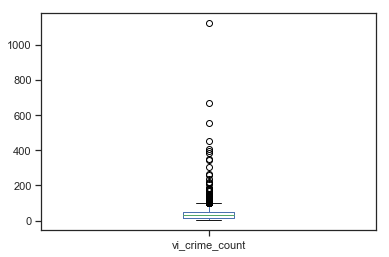

In [45]:
spatial_data['vi_crime_count'].plot(kind='box')

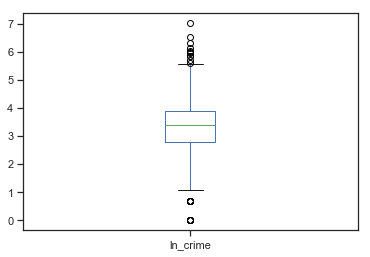

In [46]:
# trim data, reduce high outliers to 150, to better map the data
spatial_data['ln_crime'] = np.log(spatial_data['vi_crime_count'])
spatial_data['ln_crime'].plot(kind='box')

Text(0.5, 1.0, 'Ln of Crime Count across Manchester LSOAs')

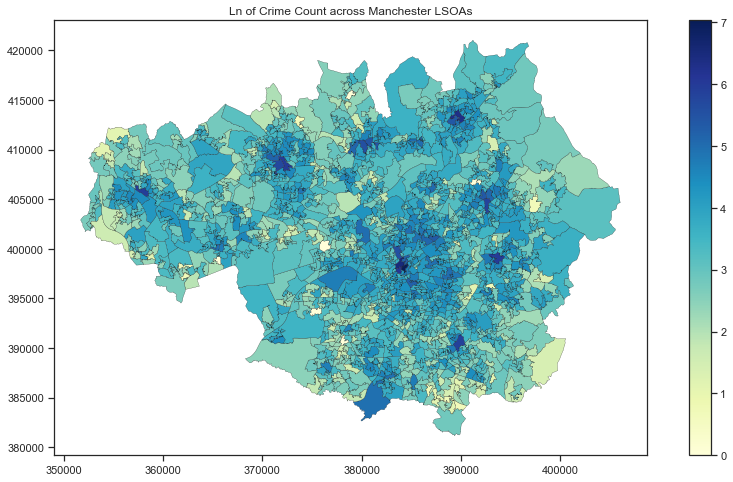

In [51]:
# Map with (trimmed) crime counts
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

spatial_data.plot(ax=ax,
                  column='ln_crime', 
                  cmap='YlGnBu',
                  linewidth=0.2, edgecolor='black',
                  legend=True
                 )\
            .set_title("Ln of Crime Count across Manchester LSOAs")

In [52]:
to_keep_z.append('ln_crime')
man_data = spatial_data[to_keep_z].drop('vi_crime_count', axis = 1)
man_data.columns = man_data.columns.str.replace("+", "")
man_data.head()

,age_median_z,badhealth_z,studenthhold_z,onefam_hhold_z,eth_hhi_z,depr_2_z,nocars_z,ln_crime
GEO_CODE,,,,,,,,
E01004766,0.630702,0.284958,-0.161325,-0.855892,-0.031264,0.130367,0.360701,3.433987
E01004767,0.172698,-0.652414,0.115203,-0.440988,-0.080929,-0.522746,-0.309699,3.663562
E01004768,0.630702,-1.784057,-0.199303,1.621328,0.561534,-1.688907,-1.530434,1.945910
E01004769,0.707036,-1.135634,-0.199303,0.309636,0.248769,-1.226136,-0.992417,2.833213
E01004770,1.088706,-0.425316,-0.199303,1.076275,-0.552008,-0.748641,-0.921466,2.564949


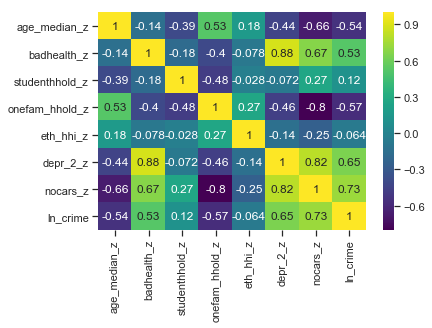

In [53]:
sns.heatmap(man_data.corr(),
            annot=True,
            cmap='viridis')

### Model w/o cross-validation

Keep nocars_z, as it seems to have the best correlation and then variables which aren't highly correlated with nocars_z --> studenthhold_z and eth_hhi_z

In [168]:
# Make the model
m1 = sm.ols('ln_crime ~ studenthhold_z + eth_hhi_z + nocars_z', man_data).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_crime   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     700.5
Date:                Tue, 12 Mar 2019   Prob (F-statistic):          1.04e-294
Time:                        17:02:21   Log-Likelihood:                -1453.1
No. Observations:                1673   AIC:                             2914.
Df Residuals:                    1669   BIC:                             2936.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.3114      0.014    234.571      0.000       3.284       3.339
studenthhold_z    -0.0750      0.015     -5.120      0.000      -0.104      -0.046
eth_hhi_z          0.1138      0.015      7.799      0.000       0.085       0.142
nocars_z           0.6826      0.015     45.106      0.000       0.653       0.712
==============================================================================
Omnibus:                      132.092   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              438.517
Skew:                          -0.355   Prob(JB):                     5.99e-96
Kurtosis:                       5.405   Cond. No.                         1.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

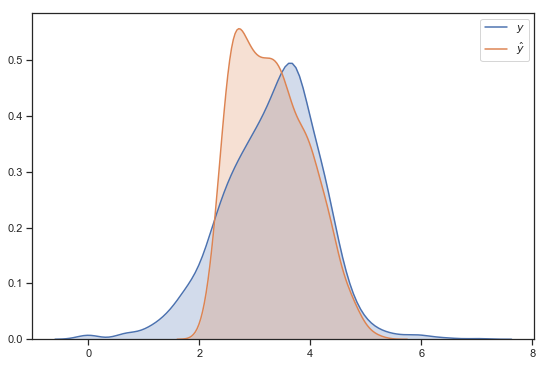

In [169]:
# compare distributions of predicted and actual values

f, ax = plt.subplots(1, figsize=(9, 6))
sns.kdeplot(man_data['ln_crime'], shade=True, ax=ax, label='$y$')
sns.kdeplot(m1.fittedvalues, shade=True, ax=ax, label='$\hat{y}$')
plt.show()

### Model Performance

In [170]:
r2 = pd.Series({'m1': metrics.r2_score(man_data['ln_crime'], m1.fittedvalues)}) # R^2
mae = pd.Series({'m1': metrics.mean_squared_error(man_data['ln_crime'], m1.fittedvalues)}) # Mean Squared Error
mse = pd.Series({'m1': metrics.mean_absolute_error(man_data['ln_crime'], m1.fittedvalues)}) # Mean Absolute Error

perf = pd.DataFrame({'MAE': mae, 'MSE': mse, 'R^2': r2})
perf

,MAE,MSE,R^2
m1,0.332606,0.428476,0.55736


### Cross validation

In [171]:
man_data.head()

,age_median_z,badhealth_z,studenthhold_z,onefam_hhold_z,eth_hhi_z,depr_2_z,nocars_z,ln_crime
GEO_CODE,,,,,,,,
E01004766,0.630702,0.284958,-0.161325,-0.855892,-0.031264,0.130367,0.360701,3.433987
E01004767,0.172698,-0.652414,0.115203,-0.440988,-0.080929,-0.522746,-0.309699,3.663562
E01004768,0.630702,-1.784057,-0.199303,1.621328,0.561534,-1.688907,-1.530434,1.945910
E01004769,0.707036,-1.135634,-0.199303,0.309636,0.248769,-1.226136,-0.992417,2.833213
E01004770,1.088706,-0.425316,-0.199303,1.076275,-0.552008,-0.748641,-0.921466,2.564949


In [178]:
# make training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(man_data[['studenthhold_z', 'eth_hhi_z', 'nocars_z']], man_data['ln_crime'], test_size= 0.2, random_state=1234)

In [180]:
# Train a model
m1_f = 'ln_crime ~ studenthhold_z + eth_hhi_z + nocars_z'
m1_tr = sm.ols(m1_f, x_train.assign(ln_crime=y_train)).fit()

In [181]:
#Compare baseline model (Model 1) with the trained model outputs
pd.DataFrame({'Full Dataset': m1.params,
              'Train Set': m1_tr.params})

,Full Dataset,Train Set
Intercept,3.311393,3.322156
eth_hhi_z,0.113831,NaN
nocars_z,0.682587,0.638596
studenthhold_z,-0.075033,NaN


In [182]:
#Extract the R-squared statistics of the two models and compare. 
pd.Series({'Full Dataset': m1.rsquared,
              'Train Set': m1_tr.rsquared})

Full Dataset    0.557360
Train Set       0.546668
dtype: float64

In [183]:
m1_tr.params.drop('Intercept')

nocars_z    0.638596
dtype: float64

In [184]:
# Now Test on the Test Data
y_pred = m1_tr.predict(x_test)

pd.Series({'0-Full Dataset': m1.rsquared,
           '1-Train Set': m1_tr.rsquared,
           '2-Test Set': metrics.r2_score(y_test, y_pred)})

0-Full Dataset    0.557360
1-Train Set       0.546668
2-Test Set        0.485717
dtype: float64

In [185]:
rids = np.arange(man_data.shape[0])
np.random.shuffle(rids)
r2s = model_selection.cross_val_score(LinearRegression(),
                                      man_data.iloc[rids, :][['studenthhold_z', 'eth_hhi_z', 'nocars_z']],
                                      man_data.iloc[rids, :]['ln_crime'],
                                      cv=10,
                                      scoring='r2')
print(r2s)
r2s.mean()

[0.59690605 0.45382889 0.48600715 0.57286876 0.58355664 0.53524602
 0.45992179 0.55984682 0.53798626 0.5018668 ]


0.5288035188993156

# Random Forest

In [189]:
m2 = RandomForestRegressor().fit(man_data[['studenthhold_z', 'eth_hhi_z', 'nocars_z']], man_data['ln_crime'])\
                            .predict(man_data[['studenthhold_z', 'eth_hhi_z', 'nocars_z']])

C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [190]:
rf = pd.Series({'R^2': metrics.r2_score(man_data['ln_crime'], m2), 
                'MSE': metrics.mean_squared_error(man_data['ln_crime'], m2),
                'MAE': metrics.mean_absolute_error(man_data['ln_crime'], m2)})
pd.concat([perf, pd.DataFrame({'RF': rf}).T])

C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,MAE,MSE,R^2
m1,0.332606,0.428476,0.557360
RF,0.180641,0.068961,0.908225


In [191]:
m2_cv = RandomForestRegressor().fit(x_train, y_train)\
                               .predict(x_test)

rf_cv = pd.Series({'R^2': metrics.r2_score(y_test, m2_cv), 
                   'MSE': metrics.mean_squared_error(y_test, m2_cv),
                   'MAE': metrics.mean_absolute_error(y_test, m2_cv)})

pd.concat([perf, pd.DataFrame({'RF': rf}).T, pd.DataFrame({'RF-CV': rf_cv}).T])

C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,MAE,MSE,R^2
m1,0.332606,0.428476,0.557360
RF,0.180641,0.068961,0.908225
RF-CV,0.554709,0.555281,0.251443


## References

Crime
1. https://journals.sagepub.com/doi/abs/10.1177/0038038596030002007
2. https://www.tandfonline.com/doi/abs/10.1080/135048598354483
3. https://www.emeraldinsight.com/doi/abs/10.1108/17578041111171050
4. https://www.taylorfrancis.com/books/e/9781351908993/chapters/10.4324/9781315246086-14
5. https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1745-9125.1984.tb00314.x
6. https://www.sciencedirect.com/science/article/pii/S1521693412001265
7. https://www.taylorfrancis.com/books/9781317864509
8. https://journals.sagepub.com/doi/abs/10.1258/rsmmsl.45.3.225
9. https://jech.bmj.com/content/62/12/1064.short
10. https://emj.bmj.com/content/31/12/986.short
11. https://mpra.ub.uni-muenchen.de/44884/
12. https://injuryprevention.bmj.com/content/17/5/319.short
13. https://academic.oup.com/bjc/article-abstract/53/6/1050/418215


Methods
